In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle
from KDEpy import FFTKDE

In [2]:
sys.path.insert(1, '../data_preprocessing/')

In [3]:
from QM9file import *
from QM7bfile import *

In [4]:
qm9_data = np.load('../data/qm9_labels_cm.npz')
qm7b_data = np.load('../data/qm7b_labels_cm.npz')

In [5]:
G_qm9 = qm9_data['G']
H_qm9 = qm9_data['H']
L_qm9 = qm9_data['L']

G_zindo = qm7b_data['G_ZINDO']
H_zindo = qm7b_data['H_ZINDO']
L_zindo = qm7b_data['L_ZINDO']

G_pbe0 = qm7b_data['G_PBE0']
H_pbe0 = qm7b_data['H_PBE0']
L_pbe0 = qm7b_data['L_PBE0']

G_gw = qm7b_data['G_GW']
H_gw = qm7b_data['H_GW']
L_gw = qm7b_data['L_GW']

In [6]:
labels_qm9 = qm9_data['labels']
labels_qm7b = qm7b_data['labels']

In [7]:
def group_by_label(a, labels):
    a_subsets = []
    u_labels = np.unique(labels)
    for ul in u_labels:
        a_tmp = []
        for ai, l in zip(a, labels):
            if l == ul:
                a_tmp.append(ai)
        a_subsets.append(np.asarray(a_tmp))
    return (a_subsets, u_labels)

In [8]:
G_qm9_subsets, ul = group_by_label(G_qm9, labels_qm9)
G_zindo_subsets, ul = group_by_label(G_zindo, labels_qm7b)

In [9]:
def get_kde_fit(values):
    x = np.linspace(np.amin(values) - 1., np.amax(values) + 1., num=1000, endpoint=True)
    values_fit = FFTKDE(bw='silverman').fit(values)
    values_kde = values_fit.evaluate(x)
    bw = values_fit.bw
    return (x, values_kde, bw)

In [10]:
x_G_qm9, G_qm9_kde, bw_G_qm9 = get_kde_fit(G_qm9)
x_H_qm9, H_qm9_kde, bw_H_qm9 = get_kde_fit(H_qm9)
x_L_qm9, L_qm9_kde, bw_L_qm9 = get_kde_fit(L_qm9)

In [11]:
x_G_zindo, G_zindo_kde, bw_G_zindo = get_kde_fit(G_zindo)
x_H_zindo, H_zindo_kde, bw_H_zindo = get_kde_fit(H_zindo)
x_L_zindo, L_zindo_kde, bw_L_zindo = get_kde_fit(L_zindo)

In [12]:
x_G_pbe0, G_pbe0_kde, bw_G_pbe0 = get_kde_fit(G_pbe0)
x_H_pbe0, H_pbe0_kde, bw_H_pbe0 = get_kde_fit(H_pbe0)
x_L_pbe0, L_pbe0_kde, bw_L_pbe0 = get_kde_fit(L_pbe0)

In [13]:
x_G_gw, G_gw_kde, bw_G_gw = get_kde_fit(G_gw)
x_H_gw, H_gw_kde, bw_H_gw = get_kde_fit(H_gw)
x_L_gw, L_gw_kde, bw_L_gw = get_kde_fit(L_gw)

In [14]:
from matplotlib import colors

In [15]:
def draw_kde_axes(ax, y, bin_edges, x_values, kde, xticks, yticks, xlim, fs, lcol, bcol):
    
    ax.hist(y, bin_edges, density=True, edgecolor='k', ls='-', lw=1., fc=bcol)
    line = ax.plot(x_values, kde, lw=2., color=lcol)
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks)
    
    ax.set_xlim(xlim)
    ax.set_ylim(bottom=0.)
    
    ax.minorticks_off()
    ax.tick_params(axis='both', length=5., width=2., direction='in', labelsize=fs)
    
    for side, sp in ax.spines.items():
        sp.set_linewidth(2.)
        
    return ax


def simple_kde_plot(y, x_values, kde, xticks, yticks, xlabel, bin_edges, xlim, 
                    save=False, filename='figure.png'):
    
    fs = 16. 
    col = 'royalblue'
    col_rgba = colors.to_rgba('royalblue', .5)
    
    fig = plt.figure(figsize=(4.8, 4.8), dpi=200)
    ax = fig.add_subplot(111)
    ax = draw_kde_axes(ax, y, bin_edges, x_values, kde, xticks, yticks, xlim, fs, col, col_rgba)
    
    ax.set_xlabel(xlabel, fontsize=fs)
    ax.set_ylabel(r'$\rho$', fontsize=fs)
        
    if save:
        plt.savefig(filename, bbox_to_inches='tight')
        
    return ax

In [16]:
def plot_homo_lumo_grid(x_list_qm9, kde_list_qm9, yticks_qm9, xticks_qm9, 
                        x_list_zindo, kde_list_zindo, yticks_zindo, xticks_zindo,
                        x_list_pbe0, kde_list_pbe0, yticks_pbe0, xticks_pbe0, 
                        x_list_gw, kde_list_gw, yticks_gw, xticks_gw, 
                        label_list, save=False, filename='figure.png'):
    
    fs = 16.
    
    fig = plt.figure(figsize=(7.2, 4.8), dpi=200)
    axs = fig.subplots(nrows=2, ncols=2)
    
    # qm9 first
    for (x, kde, lab) in zip(x_list_qm9, kde_list_qm9, label_list):
        l_tmp = axs[0, 0].plot(x, kde, label=lab, lw=2.)
        axs[0, 0].fill_between(x, kde, color=l_tmp[0].get_color(), alpha=.2)
        axs[0, 0].set_yticks(yticks_qm9)
        axs[0, 0].set_xticks(xticks_qm9)
        
    # the qm7b zindo
    for (x, kde, lab) in zip(x_list_zindo, kde_list_zindo, label_list):
        l_tmp = axs[0, 1].plot(x, kde, label=lab, lw=2.)
        axs[0, 1].fill_between(x, kde, color=l_tmp[0].get_color(), alpha=.2)
        axs[0, 1].set_yticks(yticks_zindo)
        axs[0, 1].set_xticks(xticks_zindo)
    
    # then qm7b pbe0
    for (x, kde, lab) in zip(x_list_pbe0, kde_list_pbe0, label_list):
        l_tmp = axs[1, 0].plot(x, kde, label=lab, lw=2.)
        axs[1, 0].fill_between(x, kde, color=l_tmp[0].get_color(), alpha=.2)
        axs[1, 0].set_yticks(yticks_pbe0)
        axs[1, 0].set_xticks(xticks_pbe0)
    
    # then qm7b gw
    for (x, kde, lab) in zip(x_list_gw, kde_list_gw, label_list):
        l_tmp = axs[1, 1].plot(x, kde, label=lab, lw=2.)
        axs[1, 1].fill_between(x, kde, color=l_tmp[0].get_color(), alpha=.2)
        axs[1, 1].set_yticks(yticks_gw)
        axs[1, 1].set_xticks(xticks_gw)
    
    # legend
    axs[0, 0].legend(fontsize=fs, frameon=False, ncol=3, loc='center', 
                     bbox_to_anchor=(1., 1.15), bbox_transform=axs[0, 0].transAxes)
    
#     ax.set_xlabel(r'$E$ [eV]', fontsize=fs)
#     ax.set_ylabel('count density', fontsize=fs)

    for axc in axs:
        for ax in axc:
            ax.tick_params(axis='both', labelsize=fs, direction='in', width=2., length=5.)
            ax.set_ylim(bottom=0.0)
            for side, sp in ax.spines.items():
                sp.set_linewidth(2)
        
    if save:
        plt.savefig(filename, bbox_inches='tight', format='svg')
    
    return

In [17]:
x_list_qm9 = [x_H_qm9, x_L_qm9, x_G_qm9]
kde_list_qm9 = [H_qm9_kde, L_qm9_kde, G_qm9_kde]
yticks_qm9 = [0.0, 0.2, 0.4, 0.6, 0.8]
xticks_qm9 = [-10, -5, 0, 5, 10, 15]

In [18]:
np.amax(G_qm9)

16.928203383629135

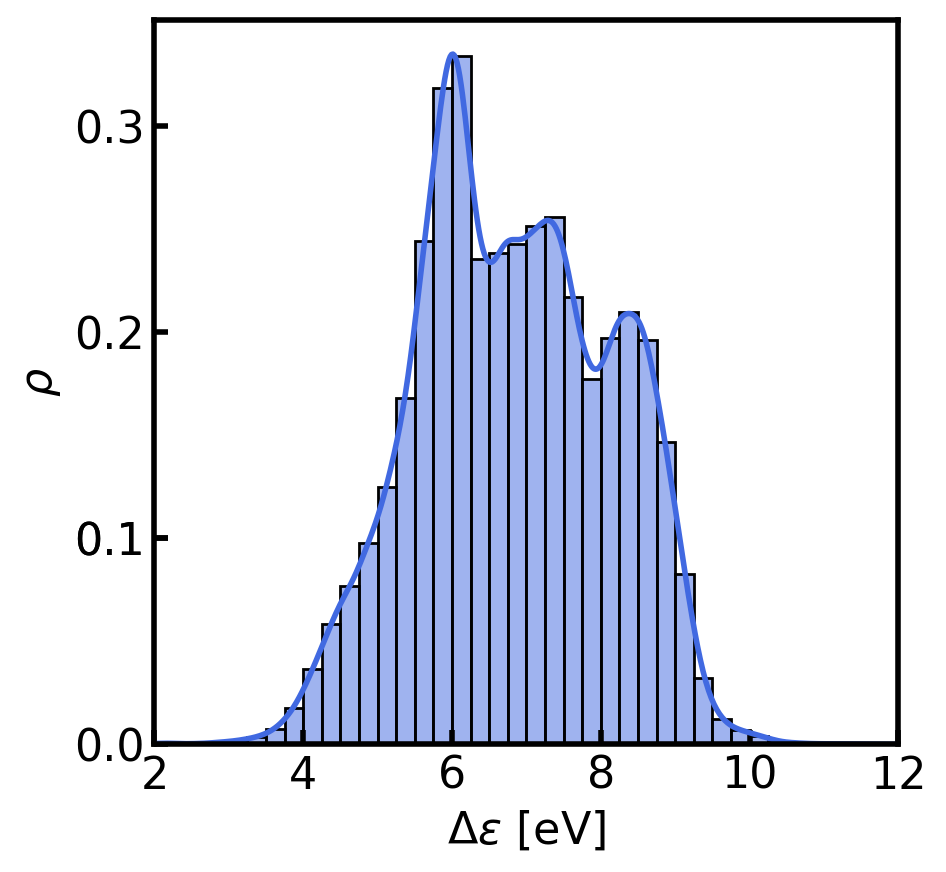

In [19]:
xticks_G_qm9 = np.linspace(0, 20, num=11, endpoint=True).astype(int)
yticks_G_qm9 = [0.0, 0.1, 0.1, 0.20, 0.30]
xlabel_G = r'$\Delta \epsilon$ [eV]'
bin_edges = np.linspace(0, 20., num=81, endpoint=True)
xlim = (2., 12.)
axes_qm9_kde = simple_kde_plot(G_qm9, x_G_qm9, G_qm9_kde, xticks_G_qm9, yticks_G_qm9, xlabel_G, 
                               bin_edges, xlim, False, 'figures/tmp/qm9_gap_hist.svg')

In [20]:
from matplotlib.gridspec import GridSpec

In [21]:
def plot_histogram_grid(data, x_label, plot_labels, save=False, filename='figures/tmp/figure.png'):
    
    # data is a list with 4 elements
    # data[0] contains data for the upper left subplot
    # data[1] for the upper right sp
    # data[2] for the lower left one
    # and data[3] for the lower right one
    
    fs = 16.
    
    fig = plt.figure(figsize=(7.2, 4.8), dpi=200)
    gs = GridSpec(2, 2, figure=fig, wspace=.2, hspace=.2)
    
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    
    lcol = 'royalblue'
    bcol = colors.to_rgba('royalblue', .5)
    
    ax0 = draw_kde_axes(ax0, fs=fs, lcol=lcol, bcol=bcol, **data[0])
    ax1 = draw_kde_axes(ax1, fs=fs, lcol=lcol, bcol=bcol, **data[1])
    ax2 = draw_kde_axes(ax2, fs=fs, lcol=lcol, bcol=bcol, **data[2])
    ax3 = draw_kde_axes(ax3, fs=fs, lcol=lcol, bcol=bcol, **data[3])
    
    ax0.set_ylabel(r'$\rho$', fontsize=fs)
    ax2.set_xlabel(x_label, fontsize=fs)
    
    if save:
        plt.savefig(filename, bbox_inches='tight')
        
    return

In [22]:
xlim_qm9 = xlim
xlim_zindo = (6, 17)
xlim_pbe0 = (3, 10)
xlim_gw = (6, 13)

In [23]:
xticks_zindo = [6, 8, 10, 12, 14, 16]
yticks_zindo = [0., 0.1, 0.2, 0.3, 0.4]

xticks_pbe0 = [3, 4, 5, 6, 7, 8, 9, 10]
yticks_pbe0 = [0., 0.2, 0.4, 0.6]

xticks_gw = [6, 7, 8, 9, 10, 11, 12]
yticks_gw = [0., 0.1, 0.2, 0.3, 0.4, 0.5]

In [24]:
data = []
data.append({'y': G_zindo, 'bin_edges': bin_edges, 'x_values': x_G_zindo, 'kde': G_zindo_kde, 'xticks': xticks_zindo, 'yticks': yticks_zindo, 'xlim': xlim_zindo})
data.append({'y': G_pbe0, 'bin_edges': bin_edges, 'x_values': x_G_pbe0, 'kde': G_pbe0_kde, 'xticks': xticks_pbe0, 'yticks': yticks_pbe0, 'xlim':xlim_pbe0})
data.append({'y': G_gw, 'bin_edges': bin_edges, 'x_values': x_G_gw, 'kde': G_gw_kde, 'xticks': xticks_gw, 'yticks': yticks_gw, 'xlim': xlim_gw})
data.append({'y': G_qm9, 'bin_edges': bin_edges, 'x_values': x_G_qm9, 'kde': G_qm9_kde, 'xticks': xticks_G_qm9, 'yticks': yticks_G_qm9, 'xlim': xlim_qm9})

In [25]:
plot_labels = ['QM7b (ZINDO)', 'QM7b (PBE0)', 'QM7b (GW)', 'QM9 (B3LYP)']

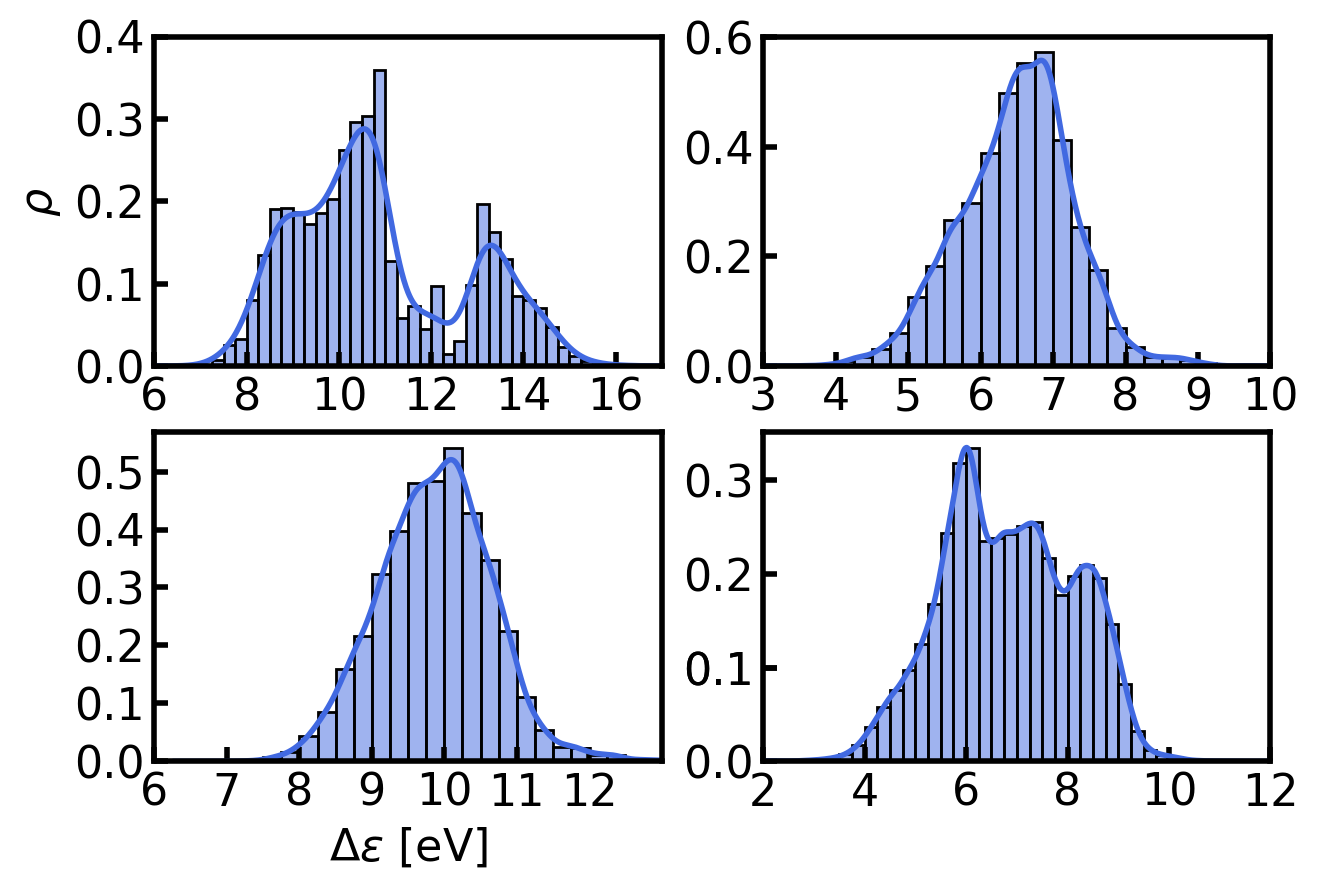

In [26]:
plot_histogram_grid(data, xlabel_G, plot_labels, save=False, filename='figures/tmp/gap_hist_grid.svg')

In [27]:
xlim_h_qm9 = (-9, -4)
xlim_h_zindo = (-14, -6)
xlim_h_pbe0 = (-10, -5)
xlim_h_gw = (-12, -6)

bin_edges_h = np.linspace(-20, 10, num=121, endpoint=True)

In [28]:
xticks_h_qm9 = [-9, -8, -7, -6, -5, -4]
yticks_h_qm9 = [0., 0.2, 0.4, 0.6, 0.8]

xticks_h_zindo = [-14, -12, -10, -8, -6]
yticks_h_zindo = [0., 0.1, 0.2, 0.3, 0.4]

xticks_h_pbe0 = [-10, -9, -8, -7, -6, -5]
yticks_h_pbe0 = [0., 0.2, 0.4, 0.6]

xticks_h_gw = [-12, -11, -10, -9, -8, -7, -6]
yticks_h_gw = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

In [29]:
data_h = []
data_h.append({'y': H_zindo, 'bin_edges': bin_edges_h, 'x_values': x_H_zindo, 'kde': H_zindo_kde, 'xticks': xticks_h_zindo, 'yticks': yticks_h_zindo, 'xlim': xlim_h_zindo})
data_h.append({'y': H_pbe0, 'bin_edges': bin_edges_h, 'x_values': x_H_pbe0, 'kde': H_pbe0_kde, 'xticks': xticks_h_pbe0, 'yticks': yticks_h_pbe0, 'xlim':xlim_h_pbe0})
data_h.append({'y': H_gw, 'bin_edges': bin_edges_h, 'x_values': x_H_gw, 'kde': H_gw_kde, 'xticks': xticks_h_gw, 'yticks': yticks_h_gw, 'xlim': xlim_h_gw})
data_h.append({'y': H_qm9, 'bin_edges': bin_edges_h, 'x_values': x_H_qm9, 'kde': H_qm9_kde, 'xticks': xticks_h_qm9, 'yticks': yticks_h_qm9, 'xlim': xlim_h_qm9})

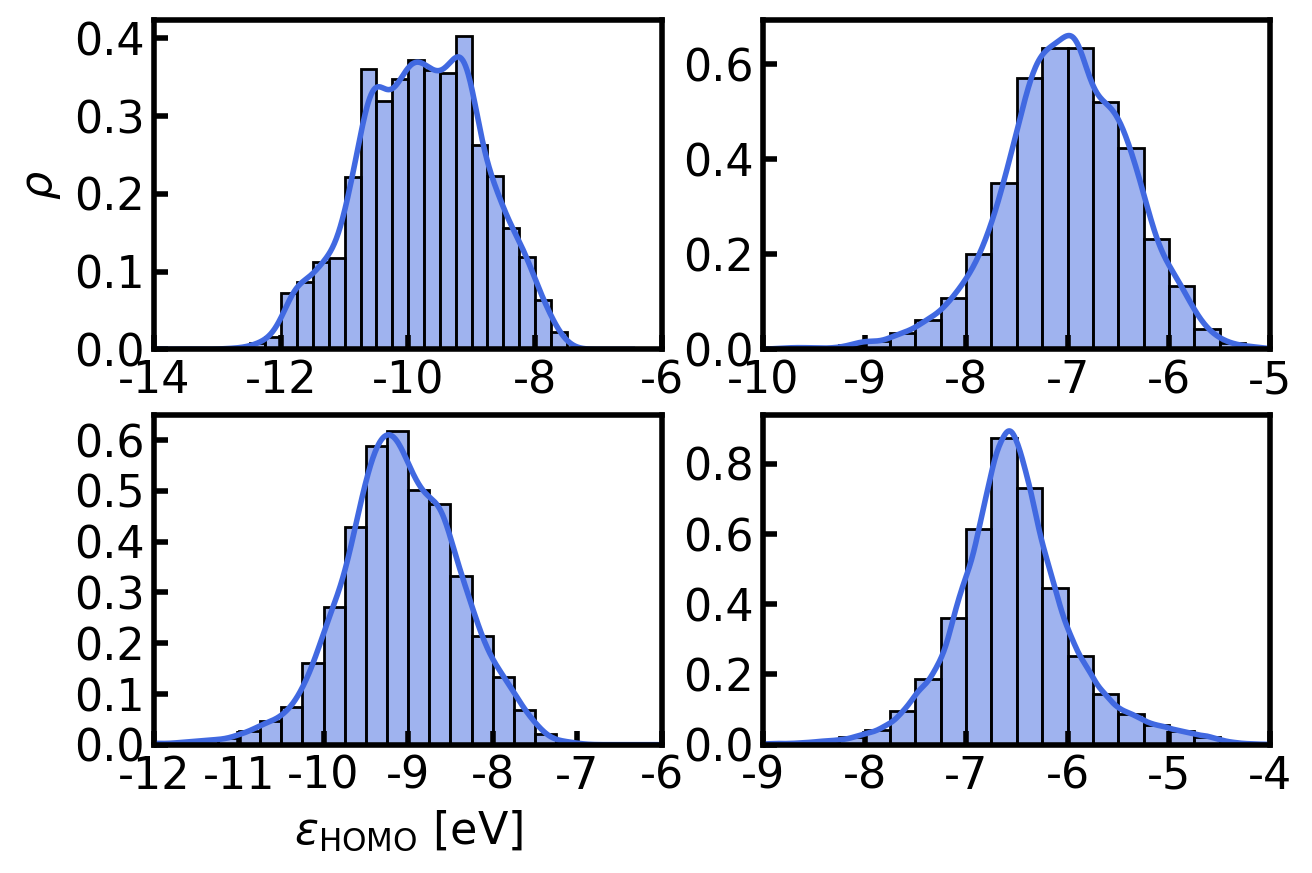

In [30]:
xlabel_H = r'$\epsilon_{\mathrm{HOMO}}$ [eV]'
plot_histogram_grid(data_h, xlabel_H, plot_labels, save=False, filename='figures/tmp/homo_hist_grid.svg')

In [31]:
xlim_l_qm9 = (-4, 4)
xlim_l_zindo = (-3, 5)
xlim_l_pbe0 = (-4, 1)
xlim_l_gw = (-2, 2)

bin_edges_l = np.linspace(-5, 5, num=41, endpoint=True)

In [32]:
xticks_l_qm9 = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
yticks_l_qm9 = [0., 0.1, 0.2, 0.3, 0.4]

xticks_l_zindo = [-3, -2, -1, 0, 1, 2, 3, 4, 5]
yticks_l_zindo = [0., 0.1, 0.2, 0.3, 0.4]

xticks_l_pbe0 = [-4, -3, -2, -1, -0, 1]
yticks_l_pbe0 = [0., 0.3, 0.6, 0.9, 1.2, 1.5]

xticks_l_gw = [-2, -1, 0, 1, 2]
yticks_l_gw = [0., 0.5, 1.0, 1.5, 2.0, 2.5]

In [33]:
data_l = []
data_l.append({'y': L_zindo, 'bin_edges': bin_edges_l, 'x_values': x_L_zindo, 'kde': L_zindo_kde, 'xticks': xticks_l_zindo, 'yticks': yticks_l_zindo, 'xlim': xlim_l_zindo})
data_l.append({'y': L_pbe0, 'bin_edges': bin_edges_l, 'x_values': x_L_pbe0, 'kde': L_pbe0_kde, 'xticks': xticks_l_pbe0, 'yticks': yticks_l_pbe0, 'xlim':xlim_l_pbe0})
data_l.append({'y': L_gw, 'bin_edges': bin_edges_l, 'x_values': x_L_gw, 'kde': L_gw_kde, 'xticks': xticks_l_gw, 'yticks': yticks_l_gw, 'xlim': xlim_l_gw})
data_l.append({'y': L_qm9, 'bin_edges': bin_edges_l, 'x_values': x_L_qm9, 'kde': L_qm9_kde, 'xticks': xticks_l_qm9, 'yticks': yticks_l_qm9, 'xlim': xlim_l_qm9})

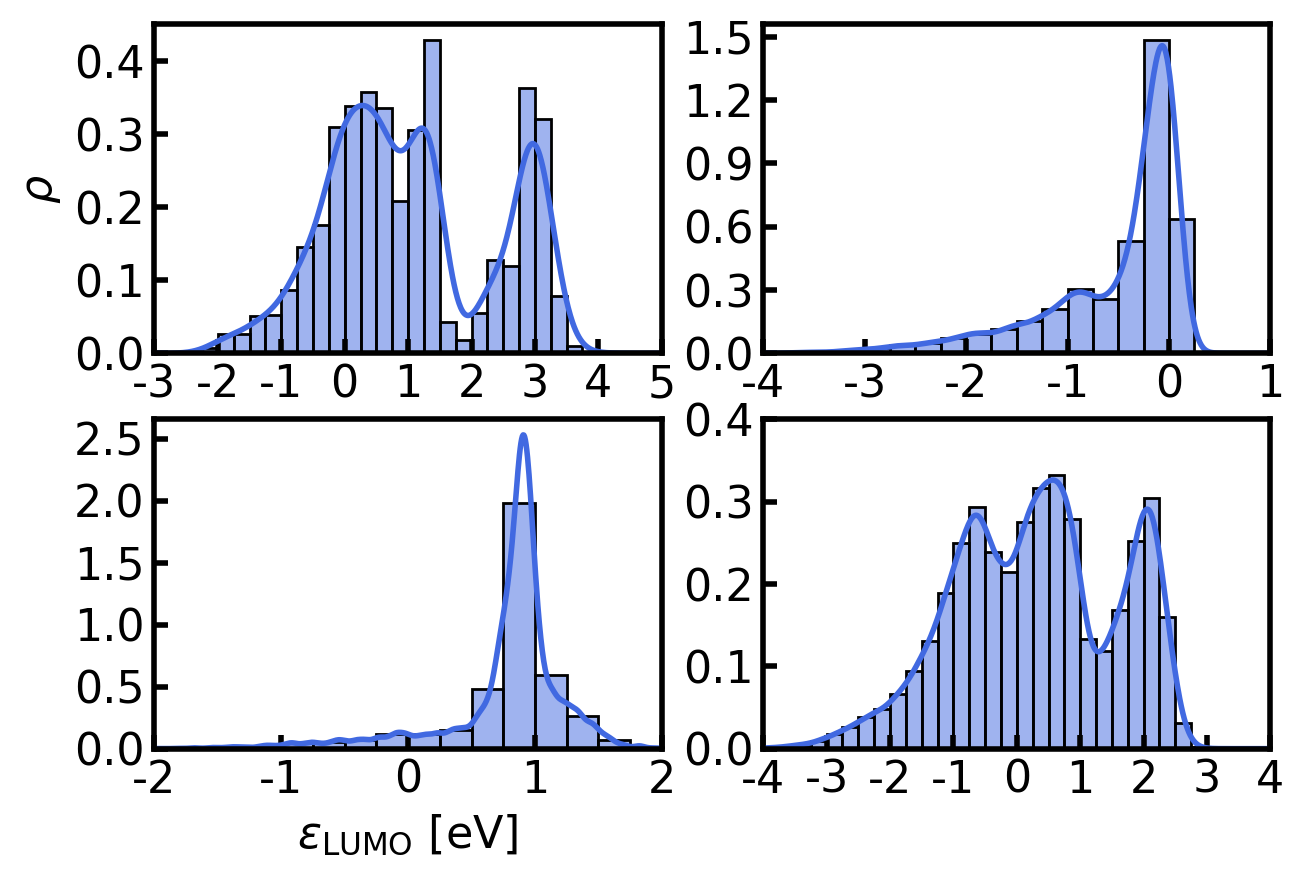

In [34]:
xlabel_L = r'$\epsilon_{\mathrm{LUMO}}$ [eV]'
plot_histogram_grid(data_l, xlabel_L, plot_labels, save=False, filename='figures/tmp/lumo_hist_grid.svg')

In [35]:
def draw_scatter_plot(ax, x_values, y_values, x_ticks, y_ticks, x_left, y_bottom, color, fs):
    
    ax.scatter(x_values, y_values, color=color, marker='.')
    
    ax.set_xlim(left=x_left)
    ax.set_ylim(bottom=y_bottom)
    
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks)
    
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticks)
    
    ax.minorticks_off()
    ax.tick_params(axis='both', length=5., width=2., direction='in', labelsize=fs)
    
    for side, sp in ax.spines.items():
        sp.set_linewidth(2.)
        
    return ax


def simple_scatter_plot(x_values, y_values, x_label, y_label, x_ticks, y_ticks, x_left, y_bottom, color, 
                        save=False, filename='figure.png'):
    
    fs = 16
    
    fig = plt.figure(figsize=(2.4, 2.4), dpi=200)
    ax = fig.add_subplot(111)
    
    ax = draw_scatter_plot(ax, x_values, y_values, x_ticks, y_ticks, x_left, y_bottom, color, fs)
    
    ax.set_xlabel(x_label, fontsize=fs)
    ax.set_ylabel(y_label, fontsize=fs)
    
    if save:
        plt.tight_layout()
        plt.savefig(filename)
        
    return

In [36]:
xlabel_H = r'$\epsilon_{\mathrm{HOMO}}$ [eV]'
xlabel_L = r'$\epsilon_{\mathrm{LUMO}}$ [eV]'

In [37]:
xticks_H_qm9 = [-12, -10, -8, -6, -4, -2]
xticks_G_qm9 = [0, 4, 8, 12, 16]

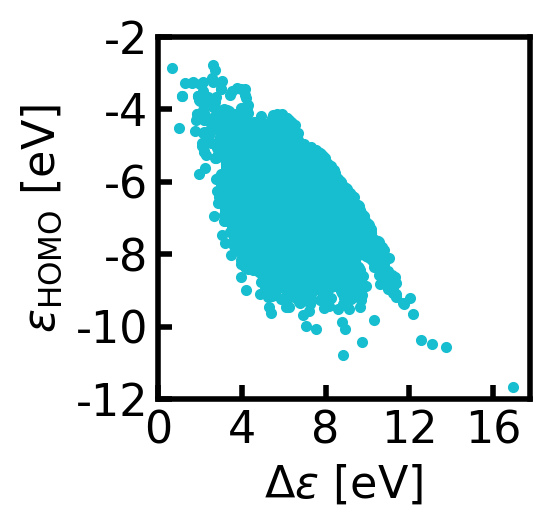

In [38]:
simple_scatter_plot(G_qm9, H_qm9, xlabel_G, xlabel_H, xticks_G_qm9, xticks_H_qm9, 
                    0., xticks_H_qm9[0], 'tab:cyan', False, 'figures/gap_homo_qm9_scatter.png')

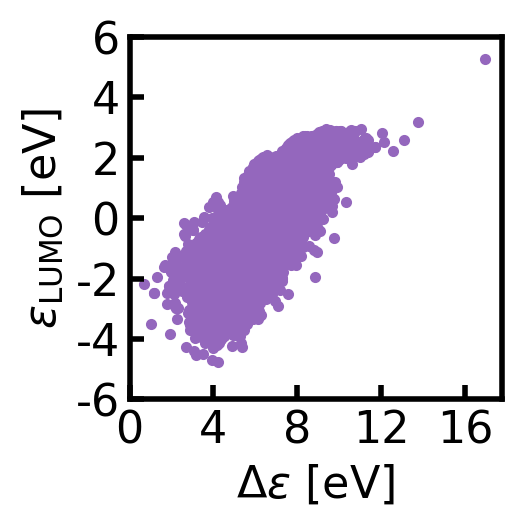

In [39]:
xticks_L_qm9 = [-6, -4, -2, 0, 2, 4, 6]
simple_scatter_plot(G_qm9, L_qm9, xlabel_G, xlabel_L, xticks_G_qm9, xticks_L_qm9, 
                    0., xticks_L_qm9[0], 'tab:purple', False, 'figures/gap_lumo_qm9_scatter.png')

In [43]:
x_ticks_homo = [0, 4, 8, 12, 16]
y_ticks_homo = [-10, -8, -6, -4, -2]

x_ticks_lumo = [0, 4, 8, 12, 16]
y_ticks_lumo = [-4, -2, 0, 2, 4, 6]

In [44]:
homo_args = {'x_homo': G_qm9, 'y_homo': H_qm9, 'y_label_homo': xlabel_H, 'x_ticks_homo': x_ticks_homo, 
             'y_ticks_homo': y_ticks_homo, 'y_bottom_homo': -12}
lumo_args = {'x_lumo': G_qm9, 'y_lumo': L_qm9, 'y_label_lumo': xlabel_L, 'x_ticks_lumo': x_ticks_lumo, 
             'y_ticks_lumo': y_ticks_lumo, 'y_bottom_lumo': -6}

In [45]:
def scatter_plots(x_homo, y_homo, y_label_homo, x_ticks_homo, y_ticks_homo, y_bottom_homo, 
                  x_lumo, y_lumo, y_label_lumo, x_ticks_lumo, y_ticks_lumo, y_bottom_lumo, 
                  x_label, save=False, filename='figures/tmp/scatter_homo_lumo.png'):
    
    fs = 16.
    homo_col = 'tab:cyan'
    lumo_col = 'tab:purple'
    
    fig = plt.figure(figsize=(2.4, 4.8), dpi=500, tight_layout=True)
    gs = GridSpec(2, 1, figure=fig, hspace=.1)
    
    ax_lumo = fig.add_subplot(gs[0, 0])
    ax_homo = fig.add_subplot(gs[1, 0])
    
    x_left = 0.
    
    ax_lumo = draw_scatter_plot(ax_lumo, x_lumo, y_lumo, x_ticks_lumo, y_ticks_lumo, 
                                x_left, y_bottom_lumo, lumo_col, fs)
    ax_homo = draw_scatter_plot(ax_homo, x_homo, y_homo, x_ticks_homo, y_ticks_homo, 
                                x_left, y_bottom_homo, homo_col, fs)
    
    ax_lumo.set_xticklabels([])
    
    ax_lumo.set_ylabel(y_label_lumo, fontsize=fs)
    ax_homo.set_ylabel(y_label_homo, fontsize=fs)
    ax_homo.set_xlabel(x_label, fontsize=fs)
    
    fig.align_labels()
    
    if save:
        plt.savefig(filename, bbox_inches='tight')
        
    return

/home/berni/src/miniconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


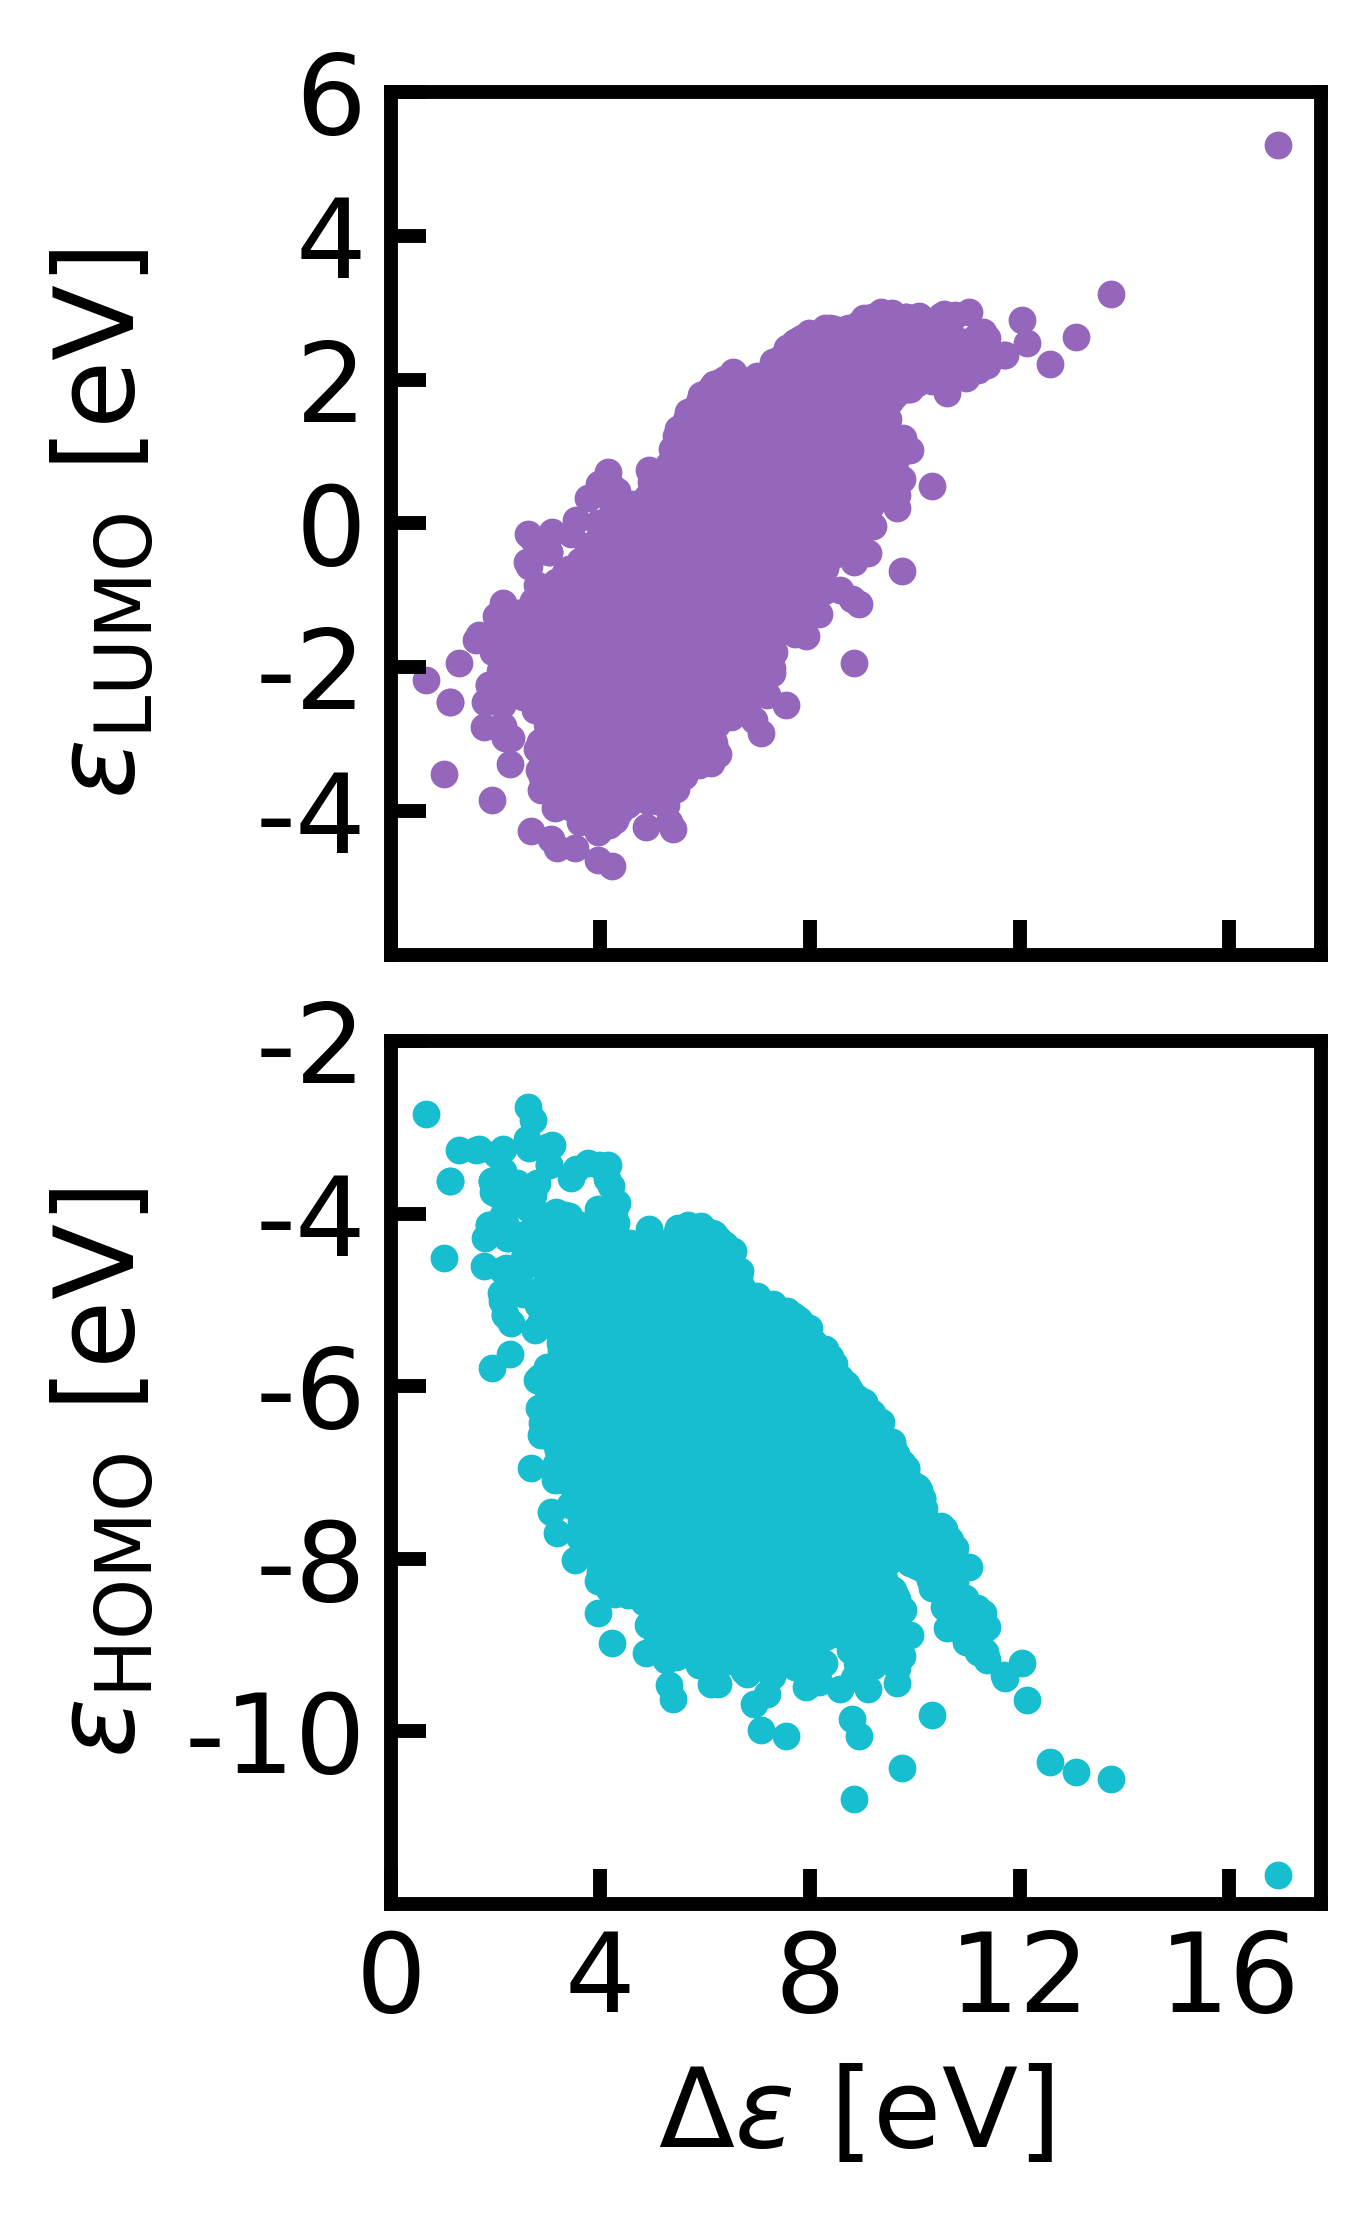

In [46]:
scatter_plots( ** homo_args, ** lumo_args, x_label=xlabel_G, 
              save=False, filename='figures/tmp/scatter_homo_lumo.png')

In [47]:
np.corrcoef(G_qm9, L_qm9)

array([[1.        , 0.89027412],
       [0.89027412, 1.        ]])

In [48]:
x_list_zindo = [x_H_zindo, x_L_zindo, x_G_zindo]
kde_list_zindo = [H_zindo_kde, L_zindo_kde, G_zindo_kde]
yticks_zindo = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
xticks_zindo = [-10, 0, 10, 20]

In [49]:
x_list_pbe0 = [x_H_pbe0, x_L_pbe0, x_G_pbe0]
kde_list_pbe0 = [H_pbe0_kde, L_pbe0_kde, G_pbe0_kde]
yticks_pbe0 = [0.0, 0.3, 0.6, 0.9, 1.2, 1.5]
xticks_pbe0 = [-10, -5, 0, 5, 10]

In [50]:
x_list_gw = [x_H_gw, x_L_gw, x_G_gw]
kde_list_gw = [H_gw_kde, L_gw_kde, G_gw_kde]
yticks_gw = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5]
xticks_gw = [-10, -5, 0, 5, 10, 15]

In [51]:
labels = [r'$\epsilon_{\mathrm{HOMO}}$', r'$\epsilon_{\mathrm{LUMO}}$', r'$\Delta \epsilon$']

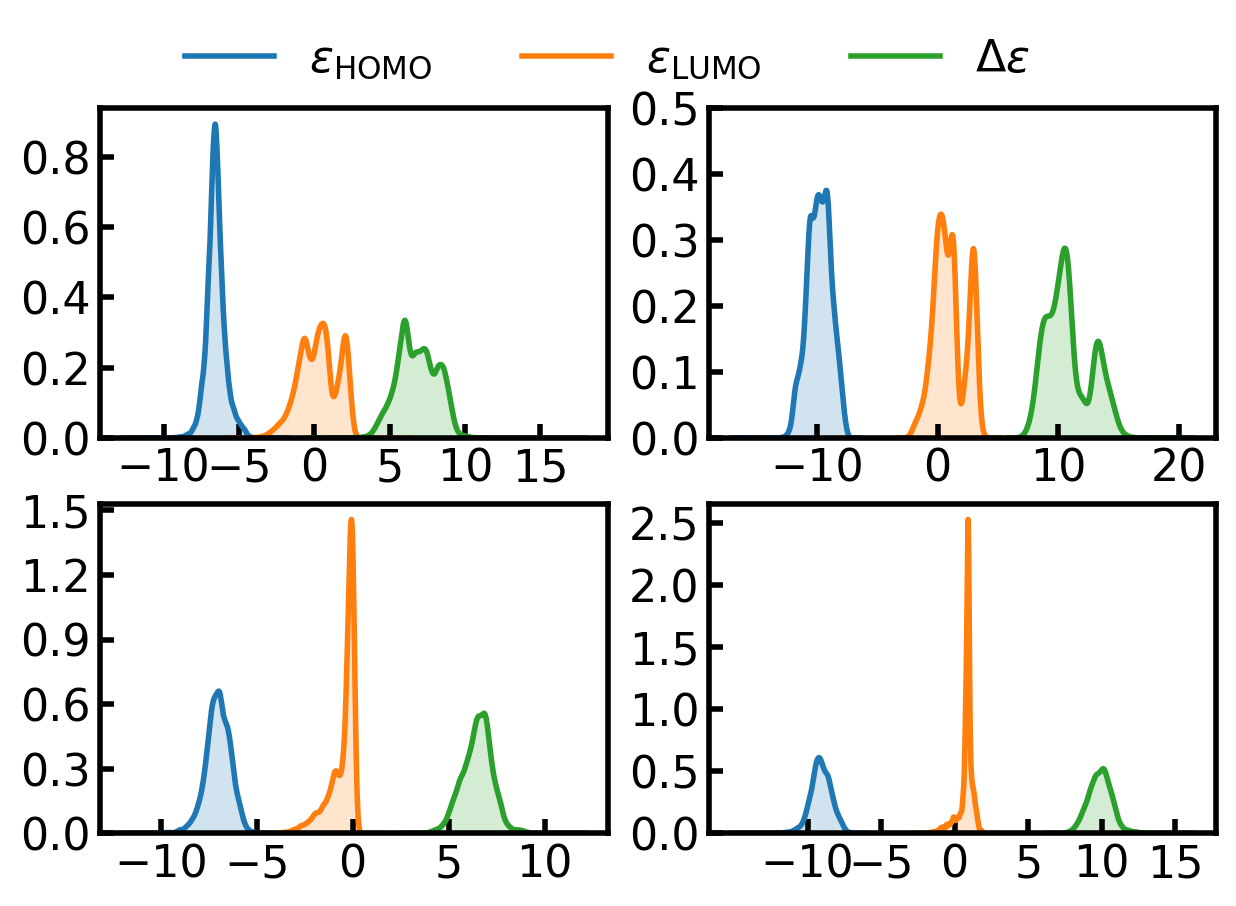

In [52]:
plot_homo_lumo_grid(x_list_qm9, kde_list_qm9, yticks_qm9, xticks_qm9, 
                    x_list_zindo, kde_list_zindo, yticks_zindo, xticks_zindo, 
                    x_list_pbe0, kde_list_pbe0, yticks_pbe0, xticks_pbe0, 
                    x_list_gw, kde_list_gw, yticks_gw, xticks_gw,
                    labels, save=False, filename='figures/densities_grid.svg')

In [53]:
from sklearn.mixture import GaussianMixture

In [54]:
means_init = np.asarray([5, 7.5, 10])

In [55]:
gmm = GaussianMixture(n_components=3, covariance_type='tied', means_init=means_init[:, np.newaxis])
gmm.fit(G_qm9[:, np.newaxis])
labels = gmm.predict(G_qm9[:, np.newaxis])
means = gmm.means_
covariances = gmm.covariances_
print(means, covariances)

[[5.81497187]
 [7.59564463]
 [8.42284248]] [[0.69124334]]


In [56]:
def plot_kde_subsets(x, val_all, val_subsets, labels, xlabel, x_ticks, y_ticks, legendoff=False,
                     xleft=None, xright=None, save=False, filename='figure.png'):
    
    fs = 16.
    
    fig = plt.figure(figsize=(3.6, 3.6), dpi=200, tight_layout=True)
    ax = fig.add_subplot(111)
    
    colors = ['royalblue', 'orange', 'forestgreen', 'firebrick']
    
    l2d = ax.plot(x, val_all['kde'], label=labels[0], lw=2., color=colors[0])
    ax.fill_between(x, val_all['kde'], color=colors[0], alpha=.2)
    for i, (sub, lab) in enumerate(zip(val_subsets, labels[1:])):
        c = len(sub['val']) / len(val_all['val'])
        l2d = ax.plot(x, c * sub['kde'], label=lab, lw=2., ls=':', color=colors[i + 1])
        ax.fill_between(x, c * sub['kde'], color=colors[i + 1], alpha=.2)
        
    if not legendoff:
        ax.legend(frameon=False, fontsize=fs)
        
    ax.set_xlabel(xlabel, fontsize=fs)
    ax.set_ylabel(r'$\rho$', fontsize=fs)
    
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    
    ax.set_ylim(bottom=0.0)
    if xleft is not None:
        ax.set_xlim(left=xleft)
    if xright is not None:
        ax.set_xlim(right=xright)
    
    ax.minorticks_off()
    ax.tick_params(axis='both', labelsize=fs, direction='in', length=5., width=2.)
    
    for side, sp in ax.spines.items():
        sp.set_linewidth(2.)
        
    if save:
        plt.savefig(filename)
        
    return

In [57]:
val_G_qm9 = {'val': G_qm9, 'kde': G_qm9_kde}
val_G_qm9_subsets = []
for val in G_qm9_subsets:
    kde = FFTKDE(bw=bw_G_qm9).fit(val).evaluate(x_G_qm9)
    val_G_qm9_subsets.append({'val': val, 'kde': kde})

In [58]:
xlabel_gap = r'$\Delta \epsilon$ [eV]'
labels_subsets = ['all', 'Class I', 'Class II', 'Class III']
yticks_G_qm9 = [0., 0.1, 0.20, 0.30]
xticks_G_qm9 = np.linspace(0.0, 12, num=7, endpoint=True)
xticks_G_qm9

array([ 0.,  2.,  4.,  6.,  8., 10., 12.])

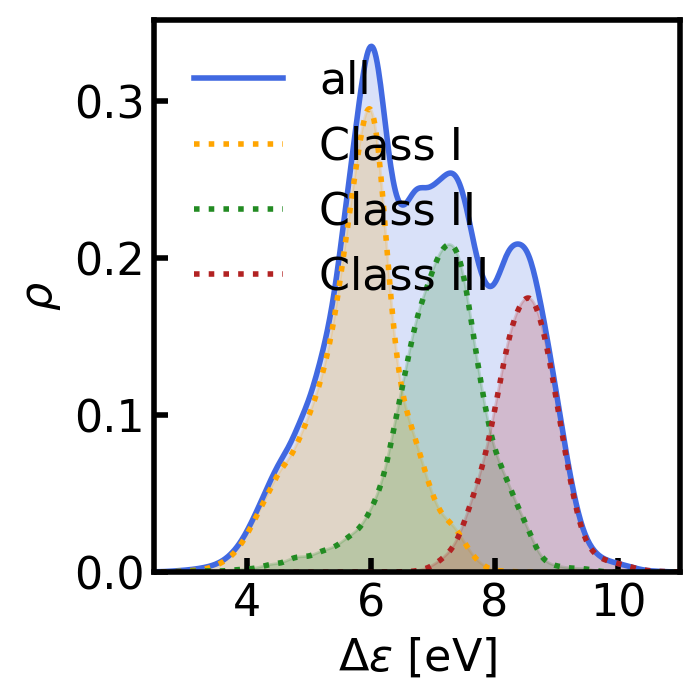

In [59]:
plot_kde_subsets(x_G_qm9, val_G_qm9, val_G_qm9_subsets, labels_subsets, xlabel_gap, xticks_G_qm9, yticks_G_qm9, 
                 legendoff=False, xleft=2.5, xright=11.,  
                 save=False, filename='figures/G_qm9_density_classification.svg')

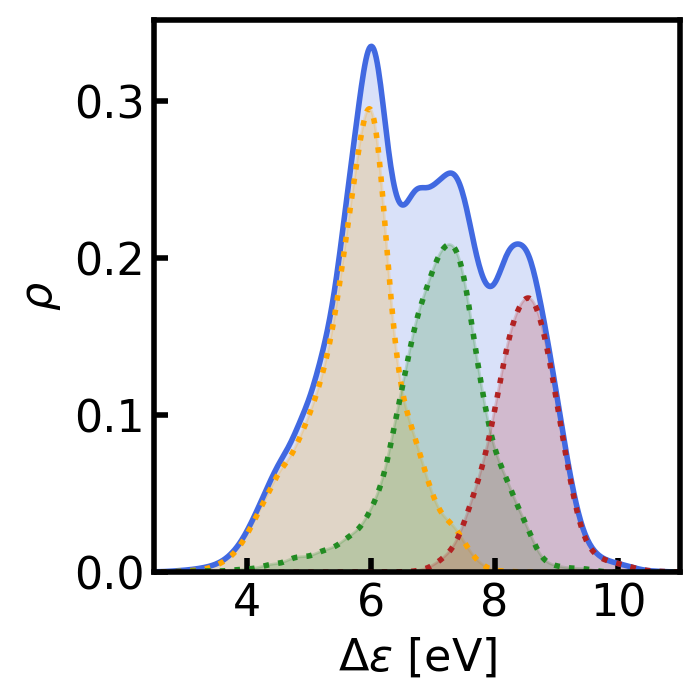

In [61]:
plot_kde_subsets(x_G_qm9, val_G_qm9, val_G_qm9_subsets, labels_subsets, xlabel_gap, xticks_G_qm9, yticks_G_qm9, 
                 legendoff=True, xleft=2.5, xright=11., save=False, filename='figures/G_qm9_density_classification_lo.svg')

In [62]:
val_G_zindo = {'val': G_zindo, 'kde': G_zindo_kde}
val_G_zindo_subsets = []
for val in G_zindo_subsets:
    kde = FFTKDE(bw=bw_G_zindo).fit(val).evaluate(x_G_zindo)
    val_G_zindo_subsets.append({'val': val, 'kde': kde})

In [63]:
G_pbe0_subsets, ul = group_by_label(G_pbe0, labels_qm7b)
G_gw_subsets, ul = group_by_label(G_gw, labels_qm7b)

In [64]:
val_G_pbe0 = {'val': G_pbe0, 'kde': G_pbe0_kde}
val_G_pbe0_subsets = []
for val in G_pbe0_subsets:
    kde = FFTKDE(bw=bw_G_pbe0).fit(val).evaluate(x_G_pbe0)
    val_G_pbe0_subsets.append({'val': val, 'kde': kde})

In [65]:
val_G_gw = {'val': G_gw, 'kde': G_gw_kde}
val_G_gw_subsets = []
for val in G_gw_subsets:
    kde = FFTKDE(bw=bw_G_gw).fit(val).evaluate(x_G_gw)
    val_G_gw_subsets.append({'val': val, 'kde': kde})

In [66]:
len(val_G_zindo_subsets)

3

In [68]:
yticks_G_zindo = [0.0, 0.1, 0.20, 0.30]
xticks_G_zindo = np.linspace(0., 20., num=11, endpoint=True)
xticks_G_zindo

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.])

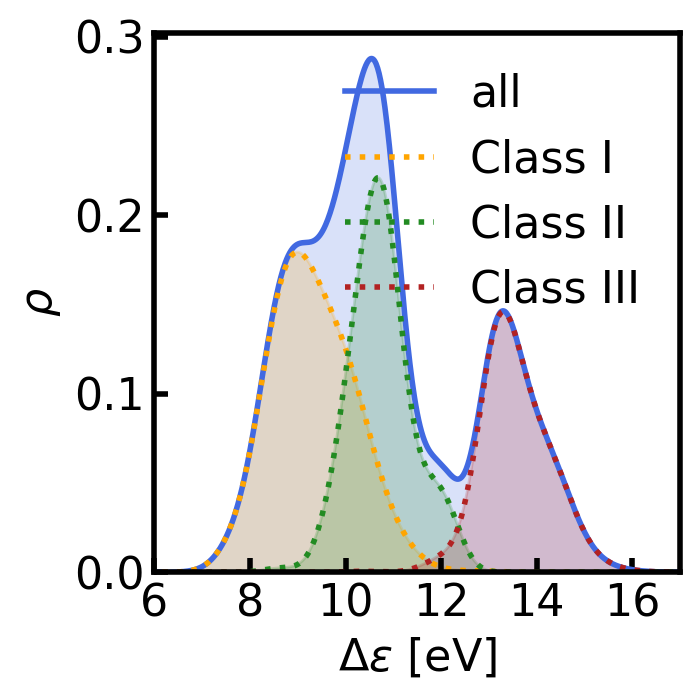

In [69]:
plot_kde_subsets(x_G_zindo, val_G_zindo, val_G_zindo_subsets, labels_subsets, xlabel_gap, xticks_G_zindo, yticks_G_zindo, 
                 legendoff=False, xleft=6., xright=17, 
                 save=False, filename='figures/G_zindo_density_classification.svg')

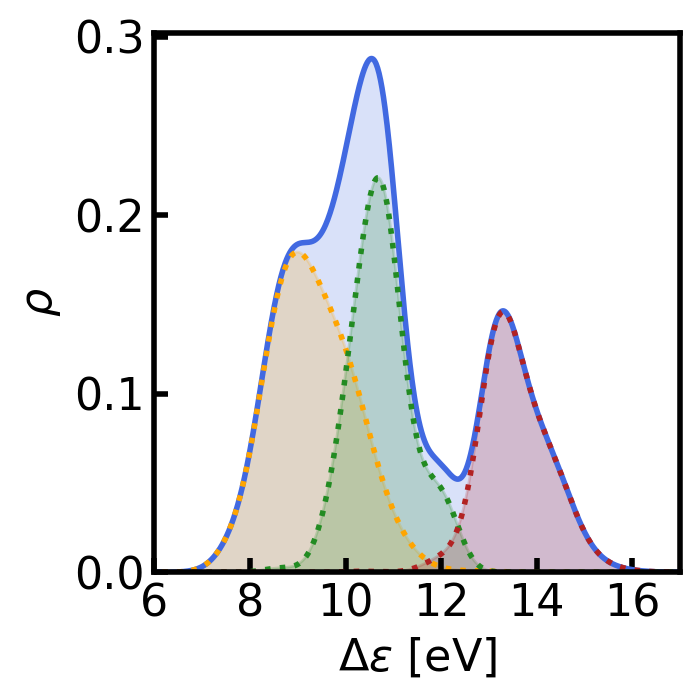

In [70]:
plot_kde_subsets(x_G_zindo, val_G_zindo, val_G_zindo_subsets, labels_subsets, xlabel_gap, xticks_G_zindo, yticks_G_zindo, 
                 legendoff=True, xleft=6., xright=17,
                 save=False, filename='figures/G_zindo_density_classification_lo.svg')

In [71]:
from matplotlib.font_manager import FontProperties

In [92]:
def match_tags(qm9_data, qm9_fa, tag, neg=False):
    matches = []
    negative = []
    for mol in qm9_data:
        index = mol['properties']['index']
        if tag in qm9_fa[index]['tags']:
            matches.append(mol)
        else:
            negative.append(mol)
    if neg:
        return (matches, negative)
    else:
        return matches

In [73]:
from frequency_analysis import *

RDKit WARNING: [16:05:12] Enabling RDKit 2019.09.3 jupyter extensions


In [75]:
os.listdir('../data/')

['qm7b_tree_006400.npz',
 'qm9_tree_128000.npz',
 'qm7b_labels_cm.npz',
 'qm7b_tree_003200.npz',
 'qm9_tree_008000.npz',
 'qm9_freq_an.pkl',
 'qm9_tree_004000.npz',
 'qm9_tree_016000.npz',
 'dsgdb9nsd.xyz.tar.bz2',
 'qm7b_tree_000800.npz',
 'qm7b_tree_000400.npz',
 'qm9_tree_064000.npz',
 'qm9_labels_cm.npz',
 'qm7b_tree_000100.npz',
 'qm7b_freq_an.pkl',
 'qm7b_labels_cm_lda.npz',
 'dsgdb7njp.xyz',
 'qm9_tree_032000.npz',
 'qm9_tree_002000.npz',
 'qm9_tree_001000.npz',
 'qm7b_tree_001600.npz',
 'qm7b_tree_000200.npz',
 'qm9_labels_cm_lda.npz']

In [77]:
qm9_all = load_qm9_data('../data/', 'dsgdb9nsd.xyz.tar.bz2')
qm7b_all = read_qm7b_file('../data/dsgdb7njp.xyz')

In [81]:
with open('../data/qm9_freq_an.pkl', 'rb') as inf:
    qm9_freq_an = pickle.load(inf)

In [93]:
qm9_sat, qm9_unsat = match_tags(qm9_all, qm9_freq_an, 'fullysat', True)

In [96]:
qm9_1_unsat = match_tags(qm9_all, qm9_freq_an, '1_unsat')
qm9_gt1_unsat = match_tags(qm9_all, qm9_freq_an, 'gt1_unsat')
qm9_arom = match_tags(qm9_all, qm9_freq_an, 'aromatic')

qm9_carbon = match_tags(qm9_all, qm9_freq_an, 'carbon')
qm9_nitrogen = match_tags(qm9_all, qm9_freq_an, 'nitrogen')
qm9_oxygen = match_tags(qm9_all, qm9_freq_an, 'oxygen')
qm9_halogen = match_tags(qm9_all, qm9_freq_an, 'halogen')

qm9_co = match_tags(qm9_all, qm9_freq_an, 'C=O')
qm9_co2on = match_tags(qm9_all, qm9_freq_an, '(O,N)C=O')
qm9_imine = match_tags(qm9_all, qm9_freq_an, 'imine')

qm9_co2o = match_qm9_molecules(qm9_co, match_carbonyl_to_O)
qm9_co2n = match_qm9_molecules(qm9_co, match_carbonyl_to_N)

In [97]:
def get_kde_from_prop_qm9(mols, prop, bw, x):
    hartree2ev = 27.211386245988
    val = get_qm9_property(mols, prop) * hartree2ev
    kde = FFTKDE(bw=bw).fit(val).evaluate(x)
    return {'val': val, 'kde': kde}


def get_kde_from_prop_qm7b(mols, prop, bw, x):
    val = get_qm9_property(mols, prop)
    kde = FFTKDE(bw=bw).fit(val).evaluate(x)
    return {'val': val, 'kde': kde}

In [98]:
qm9_sat_kde = get_kde_from_prop_qm9(qm9_sat, 'gap', bw_G_qm9, x_G_qm9)
qm9_1_unsat_kde = get_kde_from_prop_qm9(qm9_1_unsat, 'gap', bw_G_qm9, x_G_qm9)
qm9_gt1_unsat_kde = get_kde_from_prop_qm9(qm9_gt1_unsat, 'gap', bw_G_qm9, x_G_qm9)
qm9_arom_kde = get_kde_from_prop_qm9(qm9_arom, 'gap', bw_G_qm9, x_G_qm9)

qm9_carbon_kde = get_kde_from_prop_qm9(qm9_carbon, 'gap', bw_G_qm9, x_G_qm9)
qm9_nitrogen_kde = get_kde_from_prop_qm9(qm9_nitrogen, 'gap', bw_G_qm9, x_G_qm9)
qm9_oxygen_kde = get_kde_from_prop_qm9(qm9_oxygen, 'gap', bw_G_qm9, x_G_qm9)
qm9_halogen_kde = get_kde_from_prop_qm9(qm9_halogen, 'gap', bw_G_qm9, x_G_qm9)

qm9_co_kde = get_kde_from_prop_qm9(qm9_co, 'gap', bw_G_qm9, x_G_qm9)
qm9_co2n_kde = get_kde_from_prop_qm9(qm9_co2n, 'gap', bw_G_qm9, x_G_qm9)
qm9_co2o_kde = get_kde_from_prop_qm9(qm9_co2o, 'gap', bw_G_qm9, x_G_qm9)
qm9_imine_kde = get_kde_from_prop_qm9(qm9_imine, 'gap', bw_G_qm9, x_G_qm9)

In [102]:
def gridplot_frequency_analysis(x_tot, y_dict_tot, y_dict_list, labels, x_label, xticks, yticks, 
                                xleft=None, xright=None, save=False, filename='plot.svg'):
    
    fs = 16.
    nrows = 3
    ncols = 4
    
    fig = plt.figure(figsize=(7.2, 4.8), dpi=200, tight_layout=True)
    axes = fig.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, 
                        gridspec_kw={'wspace': 0., 'hspace': 0.})
    
    k = 0
    for ri in range(nrows):
        for ci in range(ncols):
            
            l2d_tot = axes[ri, ci].plot(x_tot, y_dict_tot['kde'], lw=2., zorder=2., color='royalblue')
            axes[ri, ci].fill_between(x_tot, y_dict_tot['kde'], color=l2d_tot[0].get_c(), alpha=.2, zorder=1.9)
            N = len(y_dict_list[k]['val']) / len(y_dict_tot['val'])
            l2d_sub = axes[ri, ci].plot(x_tot, N * y_dict_list[k]['kde'], label=labels[k], lw=2., zorder=2.2, 
                                        ls=':', color='midnightblue')            
            axes[ri, ci].fill_between(x_tot, N * y_dict_list[k]['kde'], color=l2d_sub[0].get_c(), alpha=.2, 
                                      zorder=2.1)
            k += 1
            
            # print(l2d_tot[0].zorder, l2d_sub[0].zorder)
            
            # axes[ri, ci].legend(frameon=False, fontsize=fs)
            if (ri == 1) & (ci == 0):
                axes[ri, ci].set_ylabel(r'$\rho$', fontsize=fs)
            if (ri ==2) & (ci == 1):
                axes[ri, ci].set_xlabel(x_label, fontsize=fs)
            
            axes[ri, ci].minorticks_off()
    
            if (ri == 0) & (ci == 0):
                axes[ri, ci].set_yticks(yticks)
                axes[ri, ci].set_yticklabels(yticks)
            else:
                axes[ri, ci].set_yticks(yticks[:-1])
                axes[ri, ci].set_yticklabels(yticks[:-1])
            
            if (ri == 2) & (ci == 3):
                axes[ri, ci].set_xticks(xticks)
                axes[ri, ci].set_xticklabels(xticks)
            else:
                axes[ri, ci].set_xticks(xticks[:-1])
                axes[ri, ci].set_xticklabels(xticks[:-1])
                
            if xleft is not None:
                axes[ri, ci].set_xlim(left=xleft)
            if xright is not None:
                axes[ri, ci].set_xlim(right=xright)
                
            axes[ri, ci].set_ylim(np.amin(yticks), np.amax(yticks))
            # axes[ri, ci].set_xlim(left=0.0)
            axes[ri, ci].tick_params(axis='both', direction='in', length=5, width=2, zorder=2.3)
            
            if ci == 0:
                axes[ri, ci].tick_params(axis='y', labelsize=fs)
            if ri == 2:
                axes[ri, ci].tick_params(axis='x', labelsize=fs)
                
            for side, sp in axes[ri, ci].spines.items():
                sp.set_linewidth(2)
                
    if save:
        plt.savefig(filename)
            
    return

In [100]:
xticks_G_qm9 = [0, 2, 4, 6, 8, 10, 12]
yticks_G_qm9 = [0.0, 0.1, 0.2, 0.3, 0.4]

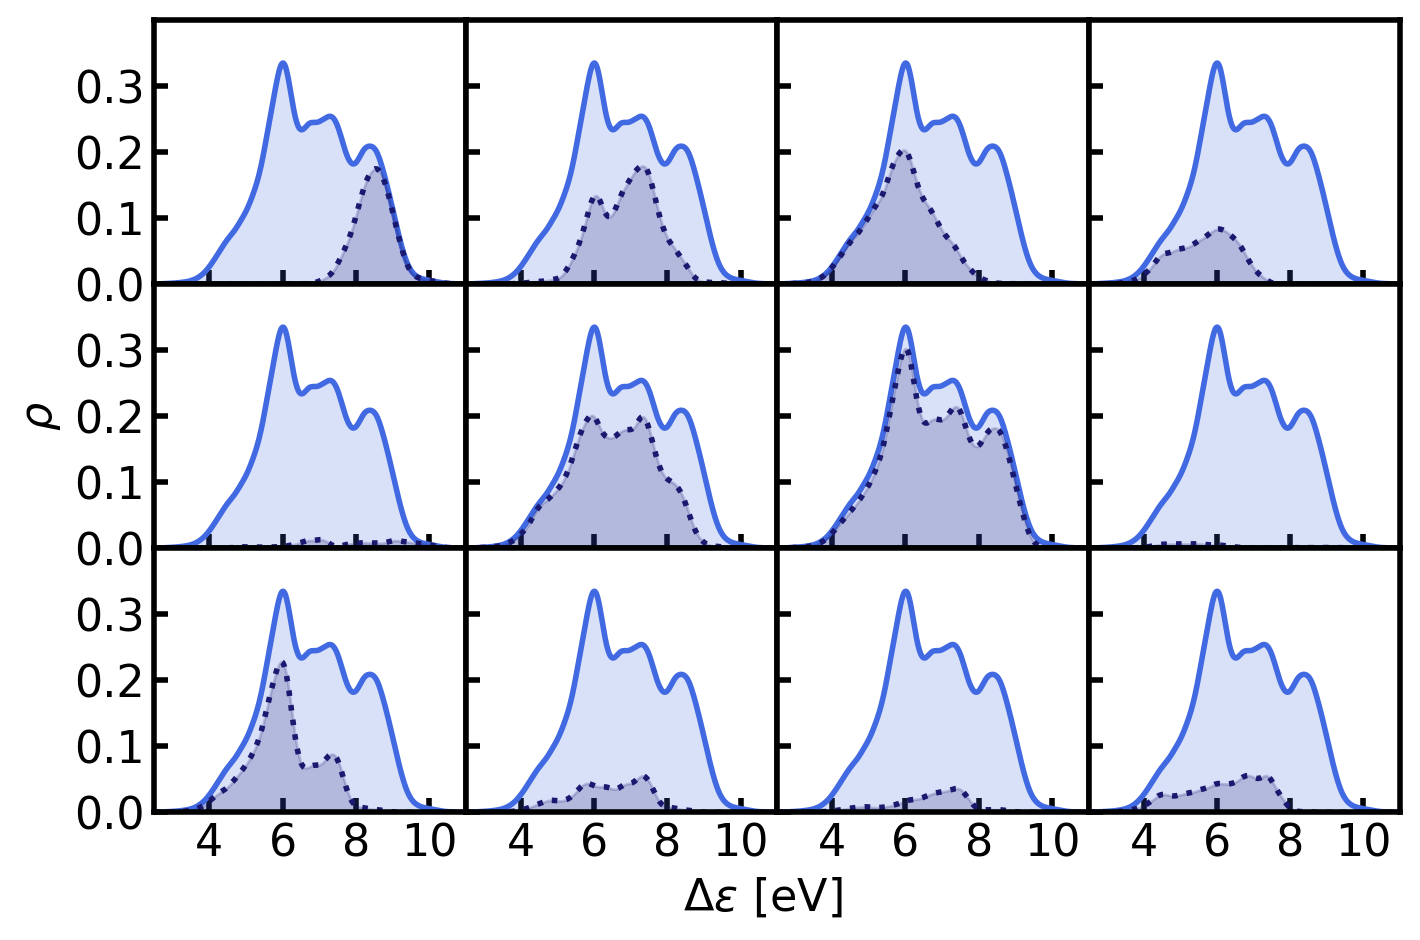

In [103]:
labels = ['sat.', '1 unsat.', '>1 unsat.', 'arom.', 
          'carbon only', 'w/ N', 'w/ O', 'w/ F', 
          'C=O', 'NC=O', 'OC=O', 'C=N']
x_label_gap_bis = f'\t\t    {xlabel_gap}'
kde_list = [qm9_sat_kde, qm9_1_unsat_kde, qm9_gt1_unsat_kde, qm9_arom_kde, 
            qm9_carbon_kde, qm9_nitrogen_kde, qm9_oxygen_kde, qm9_halogen_kde, 
            qm9_co_kde, qm9_co2n_kde, qm9_co2o_kde, qm9_imine_kde]
gridplot_frequency_analysis(x_G_qm9, val_G_qm9, kde_list, labels, x_label_gap_bis, xticks_G_qm9, yticks_G_qm9, 
                            xleft=2.5, xright=11., 
                            save=False, filename='figures/qm9/kde/frequency_analysis.svg')

In [104]:
qm7b_all[0]['properties'].keys()

dict_keys(['ae_pbe0', 'p_pbe0', 'p_scs', 'homo_gw', 'homo_pbe0', 'homo_zindo', 'lumo_gw', 'lumo_pbe0', 'lumo_zindo', 'ip_zindo', 'ea_zindo', 'e1_zindo', 'emax_zindo', 'imax_zindo'])

In [120]:
def match_tags_qm7b(qm7b_data, qm7b_fa, tag, neg=False):
    matches = []
    negative = []
    for i, mol in enumerate(qm7b_data):
        if tag in qm7b_fa[i+1]['tags']:
            matches.append(mol)
        else:
            negative.append(mol)
    if neg:
        return (matches, negative)
    else:
        return matches

In [121]:
with open('../data/qm7b_freq_an.pkl', 'rb') as inf:
    qm7b_freq_an = pickle.load(inf)

In [ ]:
sys.path.insert('../')

In [ ]:
def match_qm7b_molecules(qm7b_data, match_func, neg=False):
    """
    filters out molecules that agree with the matching function for qm7b molecules

    args: 
        qm7b_data: list of qm7b molecule data as dicts
        match_func: matching function
        neg(=False) : if True, return also those molecules that don't match

    returns: 
        match_pos : list of qm7b molecules that match
        match_neg (if neg=True): list of qm7b molecules that don't match
    
    """
    element2charge = {'H': 1, 'C': 6, 'N': 7, 'O': 8, 'S': 16, 'Cl': 17}
    pos_matches = []
    neg_matches = []
    for mol in qm7b_data:
        atoms = [element2charge[el] for el in mol['elements']]
        coords = mol['coords']
        rdmol = xyz2mol(atoms, coords)[0]
        if match_func(rdmol):
            pos_matches.append(mol)
        else:
            neg_matches.append(mol)
    if neg:
        return (pos_matches, neg_matches)
    else:
        return pos_matches

In [122]:
qm7b_sat = match_tags_qm7b(qm7b_all, qm7b_freq_an, 'fullysat')
qm7b_1_unsat = match_tags_qm7b(qm7b_all, qm7b_freq_an, '1_unsat')
qm7b_gt1_unsat = match_tags_qm7b(qm7b_all, qm7b_freq_an, 'gt1_unsat')
qm7b_arom = match_tags_qm7b(qm7b_all, qm7b_freq_an, 'aromatic')

qm7b_carbon = match_tags_qm7b(qm7b_all, qm7b_freq_an, 'carbon')
qm7b_nitrogen = match_tags_qm7b(qm7b_all, qm7b_freq_an, 'nitrogen')
qm7b_oxygen = match_tags_qm7b(qm7b_all, qm7b_freq_an, 'oxygen')
qm7b_sulfur = match_tags_qm7b(qm7b_all, qm7b_freq_an, 'sulfur')

qm7b_co = match_tags_qm7b(qm7b_all, qm7b_freq_an, 'C=O')
qm7b_co2on = match_tags_qm7b(qm7b_all, qm7b_freq_an, '(O,N)C=O')
qm7b_imine = match_tags_qm7b(qm7b_all, qm7b_freq_an, 'imine')

qm7b_co2o = match_qm7b_molecules(qm7b_co, match_carbonyl_to_O)
qm7b_co2n = match_qm7b_molecules(qm7b_co, match_carbonyl_to_N)

AttributeError: 'list' object has no attribute 'HasSubstructMatch'

In [118]:
qm7b_homoz_sat_kde = get_kde_from_prop_qm7b(qm7b_sat, 'homo_zindo', bw_H_zindo, x_H_zindo)

In [114]:
qm7b_homoz_1_unsat_kde = get_kde_from_prop_qm7b(qm7b_1_unsat, 'homo_zindo', bw_H_zindo, x_H_zindo)
qm7b_homoz_gt1_unsat_kde = get_kde_from_prop_qm7b(qm7b_gt1_unsat, 'homo_zindo', bw_H_zindo, x_H_zindo)
qm7b_homoz_arom_kde = get_kde_from_prop_qm7b(qm7b_arom, 'homo_zindo', bw_H_zindo, x_H_zindo)

qm7b_homoz_carbon_kde = get_kde_from_prop_qm7b(qm7b_carbon, 'homo_zindo', bw_H_zindo, x_H_zindo)
qm7b_homoz_nitrogen_kde = get_kde_from_prop_qm7b(qm7b_nitrogen, 'homo_zindo', bw_H_zindo, x_H_zindo)
qm7b_homoz_oxygen_kde = get_kde_from_prop_qm7b(qm7b_oxygen, 'homo_zindo', bw_H_zindo, x_H_zindo)
qm7b_homoz_sulfur_kde = get_kde_from_prop_qm7b(qm7b_sulfur, 'homo_zindo', bw_H_zindo, x_H_zindo)

qm7b_homoz_co_kde = get_kde_from_prop_qm7b(qm7b_co, 'homo_zindo', bw_H_zindo, x_H_zindo)
qm7b_homoz_co2o_kde = get_kde_from_prop_qm7b(qm7b_co2o, 'homo_zindo', bw_H_zindo, x_H_zindo)
qm7b_homoz_co2n_kde = get_kde_from_prop_qm7b(qm7b_co2n, 'homo_zindo', bw_H_zindo, x_H_zindo)
qm7b_homoz_imine_kde = get_kde_from_prop_qm7b(qm7b_imine, 'homo_zindo', bw_H_zindo, x_H_zindo)

ValueError: Data must contain at least one data point.

In [ ]:
qm7b_lumoz_sat_kde = get_kde_from_prop_qm7b(qm7b_sat, 'lumo_zindo', bw_L_zindo, x_L_zindo)
qm7b_lumoz_1_unsat_kde = get_kde_from_prop_qm7b(qm7b_1_unsat, 'lumo_zindo', bw_L_zindo, x_L_zindo)
qm7b_lumoz_gt1_unsat_kde = get_kde_from_prop_qm7b(qm7b_gt1_unsat, 'lumo_zindo', bw_L_zindo, x_L_zindo)
qm7b_lumoz_arom_kde = get_kde_from_prop_qm7b(qm7b_arom, 'lumo_zindo', bw_L_zindo, x_L_zindo)

qm7b_lumoz_carbon_kde = get_kde_from_prop_qm7b(qm7b_carbon, 'lumo_zindo', bw_L_zindo, x_L_zindo)
qm7b_lumoz_nitrogen_kde = get_kde_from_prop_qm7b(qm7b_nitrogen, 'lumo_zindo', bw_L_zindo, x_L_zindo)
qm7b_lumoz_oxygen_kde = get_kde_from_prop_qm7b(qm7b_oxygen, 'lumo_zindo', bw_L_zindo, x_L_zindo)
qm7b_lumoz_sulfur_kde = get_kde_from_prop_qm7b(qm7b_sulfur, 'lumo_zindo', bw_L_zindo, x_L_zindo)

qm7b_lumoz_co_kde = get_kde_from_prop_qm7b(qm7b_co, 'lumo_zindo', bw_L_zindo, x_L_zindo)
qm7b_lumoz_co2o_kde = get_kde_from_prop_qm7b(qm7b_co2o, 'lumo_zindo', bw_L_zindo, x_L_zindo)
qm7b_lumoz_co2n_kde = get_kde_from_prop_qm7b(qm7b_co2n, 'lumo_zindo', bw_L_zindo, x_L_zindo)
qm7b_lumoz_imine_kde = get_kde_from_prop_qm7b(qm7b_imine, 'lumo_zindo', bw_L_zindo, x_L_zindo)

In [ ]:
G_zindo_sat = qm7b_lumoz_sat_kde['val'] - qm7b_homoz_sat_kde['val']
G_zindo_1_unsat = qm7b_lumoz_1_unsat_kde['val'] - qm7b_homoz_1_unsat_kde['val']
G_zindo_gt1_unsat = qm7b_lumoz_gt1_unsat_kde['val'] - qm7b_homoz_gt1_unsat_kde['val']
G_zindo_arom = qm7b_lumoz_arom_kde['val'] - qm7b_homoz_arom_kde['val']

G_zindo_carbon = qm7b_lumoz_carbon_kde['val'] - qm7b_homoz_carbon_kde['val']
G_zindo_nitrogen = qm7b_lumoz_nitrogen_kde['val'] - qm7b_homoz_nitrogen_kde['val']
G_zindo_oxygen = qm7b_lumoz_oxygen_kde['val'] - qm7b_homoz_oxygen_kde['val']
G_zindo_sulfur = qm7b_lumoz_sulfur_kde['val'] - qm7b_homoz_sulfur_kde['val']

G_zindo_co = qm7b_lumoz_co_kde['val'] - qm7b_homoz_co_kde['val']
G_zindo_co2n = qm7b_lumoz_co2n_kde['val'] - qm7b_homoz_co2n_kde['val']
G_zindo_co2o = qm7b_lumoz_co2o_kde['val'] - qm7b_homoz_co2o_kde['val']
G_zindo_imine = qm7b_lumoz_imine_kde['val'] - qm7b_homoz_imine_kde['val']

In [ ]:
bw_G_zindo

In [ ]:
qm7b_gapz_sat_kde = {'val': G_zindo_sat, 'kde': FFTKDE(bw=bw_G_zindo).fit(G_zindo_sat).evaluate(x_G_zindo)}
qm7b_gapz_1_unsat_kde = {'val': G_zindo_1_unsat, 'kde': FFTKDE(bw=bw_G_zindo).fit(G_zindo_1_unsat).evaluate(x_G_zindo)}
qm7b_gapz_gt1_unsat_kde = {'val': G_zindo_gt1_unsat, 'kde': FFTKDE(bw=bw_G_zindo).fit(G_zindo_gt1_unsat).evaluate(x_G_zindo)}
qm7b_gapz_arom_kde = {'val': G_zindo_arom, 'kde': FFTKDE(bw=bw_G_zindo).fit(G_zindo_arom).evaluate(x_G_zindo)}

qm7b_gapz_carbon_kde = {'val': G_zindo_carbon, 'kde': FFTKDE(bw=bw_G_zindo).fit(G_zindo_carbon).evaluate(x_G_zindo)}
qm7b_gapz_nitrogen_kde = {'val': G_zindo_nitrogen, 'kde': FFTKDE(bw=bw_G_zindo).fit(G_zindo_nitrogen).evaluate(x_G_zindo)}
qm7b_gapz_oxygen_kde = {'val': G_zindo_oxygen, 'kde': FFTKDE(bw=bw_G_zindo).fit(G_zindo_oxygen).evaluate(x_G_zindo)}
qm7b_gapz_sulfur_kde = {'val': G_zindo_sulfur, 'kde': FFTKDE(bw=bw_G_zindo).fit(G_zindo_sulfur).evaluate(x_G_zindo)}

qm7b_gapz_co_kde = {'val': G_zindo_co, 'kde': FFTKDE(bw=bw_G_zindo).fit(G_zindo_co).evaluate(x_G_zindo)}
qm7b_gapz_co2n_kde = {'val': G_zindo_co2n, 'kde': FFTKDE(bw=bw_G_zindo).fit(G_zindo_co2n).evaluate(x_G_zindo)}
qm7b_gapz_co2o_kde = {'val': G_zindo_co2o, 'kde': FFTKDE(bw=bw_G_zindo).fit(G_zindo_co2o).evaluate(x_G_zindo)}
qm7b_gapz_imine_kde = {'val': G_zindo_imine, 'kde': FFTKDE(bw=bw_G_zindo).fit(G_zindo_imine).evaluate(x_G_zindo)}

In [ ]:
xticks_G_qm7b = [0, 2, 4, 8, 12, 16]
yticks_G_qm7b = [0., 0.1, 0.2, 0.3]

In [ ]:
labels_qm7b = ['sat.', '1 unsat.', '>1 unsat.', 'arom.', 
               'carbon only', 'w/ N', 'w/ O', 'w/ S', 
               'C=O', 'NC=O', 'OC=O', 'C=N']
x_label_gap_bis = f'\t\t    {xlabel_gap}'
kde_list_qm7b = [qm7b_gapz_sat_kde, qm7b_gapz_1_unsat_kde, qm7b_gapz_gt1_unsat_kde, qm7b_gapz_arom_kde, 
                 qm7b_gapz_carbon_kde, qm7b_gapz_nitrogen_kde, qm7b_gapz_oxygen_kde, qm7b_gapz_sulfur_kde, 
                 qm7b_gapz_co_kde, qm7b_gapz_co2n_kde, qm7b_gapz_co2o_kde, qm7b_gapz_imine_kde]
gridplot_frequency_analysis(x_G_zindo, val_G_zindo, kde_list_qm7b, labels_qm7b, x_label_gap_bis, 
                            xticks_G_qm7b, yticks_G_qm7b, xleft=6., xright=17., 
                            save=False, filename='figures/qm7b/kde/frequency_analysis.svg')